## Cross-sectional Analysis on
### PsychSignal sentiment data and AAII Sentiment Survey

### (1) Understanding Data
492 unique symbol in PsychSignal S&P500 dataset

47 Symbols occured in *current S&P500 list* but missing in PsychSignal are:

['AAL', 'AAP', 'ANTM', 'ATVI', 'BF-B', 'BRK-B', 'BXLT', 'CFG', 'CHD', 'CPGX', 'CSRA', 'CXO', 'DISCK', 'ENDP', 'EQIX', 'ES', 'EXR', 'FOX', 'FRT', 'GOOGL', 'HBI', 'HCA', 'HPE', 'HRB', 'HSIC', 'ILMN', 'JBHT', 'KHC', 'LVLT', 'NWS', 'O', 'PYPL', 'QRVO', 'RCL', 'SIG', 'SLG', 'SWKS', 'SYF', 'TGNA', 'TYC', 'UAL', 'VIAB', 'VRSK', 'WBA', 'WLTW', 'WRK', 'ZBH']

35 Symbols occured in *PyschSignal* but missing in current S&P 500 list are:

['ACE', 'ACT', 'ALTR', 'AVP', 'BMS', 'BRCM', 'CFN', 'COV', 'CSC', 'DNR', 'DTV', 'FDO', 'FOSL', 'GCI', 'GNW', 'HCBK', 'HSP', 'JBL', 'KRFT', 'LO', 'MWV', 'NBR', 'NE', 'NU', 'PCL', 'PCP', 'PETM', 'PLL', 'QEP', 'SIAL', 'SWY', 'TEG', 'WIN', 'WLP', 'ZMH']

earliest date and latest date within PsychSignal dataset are

{2009-07-10, 2016-01-04}

There are 10 unique GICS industrial sector: 

['Health Care', 'Materials', 'Industrials', 'Consumer Discretionary', 'Information Technology', 'Consumer Staples', 'Utilities', 'Financials', 'Energy', 'Telecommunications Services']

There are 336 unique AAII time stamps in PsychSignal datasets, which means we have 336 time series data (x axis) to be compared against (* need to rephrase this...)

In [2]:
__author__= 'Emily Ye Hua'
import pandas as pd

In [3]:
#816441 rows × 10 columns
df_psch = pd.read_csv('sp500_pyschsignal.csv')

In [4]:
pd.read_csv('sp500_pyschsignal.csv', nrows = 10)

,SOURCE,SYMBOL,TIMESTAMP_UTC,BULLISH_INTENSITY,BEARISH_INTENSITY,BULL_MINUS_BEAR,BULL_SCORED_MESSAGES,BEAR_SCORED_MESSAGES,BULL_BEAR_MSG_RATIO,TOTAL_SCANNED_MESSAGES
0,stocktwits+twitter_withretweets,A,2009-09-06T04:00:00Z,0.00,0.00,0.00,0,0,0,1
1,stocktwits+twitter_withretweets,A,2009-10-11T04:00:00Z,2.44,0.00,2.44,1,0,0,1
2,stocktwits+twitter_withretweets,A,2009-10-12T04:00:00Z,2.27,0.00,2.27,3,0,0,3
3,stocktwits+twitter_withretweets,A,2009-10-20T04:00:00Z,0.00,2.40,-2.40,0,1,0,2
4,stocktwits+twitter_withretweets,A,2009-10-21T04:00:00Z,0.00,0.00,0.00,0,0,0,2
5,stocktwits+twitter_withretweets,A,2009-10-22T04:00:00Z,0.00,0.00,0.00,0,0,0,1
6,stocktwits+twitter_withretweets,A,2009-11-19T05:00:00Z,0.00,1.97,-1.97,0,1,0,1
7,stocktwits+twitter_withretweets,A,2009-12-03T05:00:00Z,0.00,0.00,0.00,0,0,0,1
8,stocktwits+twitter_withretweets,A,2010-01-03T05:00:00Z,0.00,2.12,-2.12,0,1,0,1
9,stocktwits+twitter_withretweets,A,2010-01-24T05:00:00Z,0.00,2.78,-2.78,0,1,0,1


In [5]:
print("There are %d unique symbol in PsychSignal dataset"%len(list(pd.unique(df_psch['SYMBOL']))))

There are 492 unique symbol in PsychSignal dataset


#### process timestamp
transform the TIMESTAMP_UTC column to only *year-month-date* value drop the UTC time

display the earliest date in the dataset and the latest date in the dataset

In [6]:
from dateutil.parser import parse
stamp = df_psch['TIMESTAMP_UTC'].str.split('T') 
#stamp[0] = ['2009-09-06', '04:00:00Z']
#stamp[0][0] = '2009-09-06'
#let's drop the UTC part
df_psch['TIMESTAMP_UTC'] = stamp.str[0]
df_psch_sorted =df_psch.sort_values(by='TIMESTAMP_UTC')
#df_psch_sorted
#unique time stamp
unique_time_stamps = list(pd.unique(df_psch_sorted['TIMESTAMP_UTC']))
print("earliest date: %s; latest date: %s"%(df_psch['TIMESTAMP_UTC'].min(), df_psch['TIMESTAMP_UTC'].max()))

earliest date: 2009-07-10; latest date: 2016-01-04


#### GICS
Global Industry Classification Standard

In [7]:
#specifies the encode method otherwise it says utf8 can't decode byte at position 4
df_GICS = pd.read_csv('GICS.csv', encoding = "ISO-8859-1")

In [8]:
pd.read_csv('GICS.csv', nrows = 10)

,Ticker symbol,Security,GICS Sector,GICS Sub Industry,Address of Headquarters,Date first added,CIK
0,A,Agilent Technologies Inc,Health Care,Health Care Equipment & Services,"Santa Clara, California",NaN,1090872
1,AA,Alcoa Inc,Materials,Aluminum,"New York, New York",NaN,4281
2,AAL,American Airlines Group,Industrials,Airlines,"Fort Worth, Texas",3/23/15,6201
3,AAP,Advance Auto Parts,Consumer Discretionary,Automotive Retail,"Roanoke, Virginia",7/9/15,1158449
4,AAPL,Apple Inc.,Information Technology,Computer Hardware,"Cupertino, California",11/30/82,320193
5,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",12/31/12,1551152
6,ABC,AmerisourceBergen Corp,Health Care,Health Care Distribution & Services,"Chesterbrook, Pennsylvania",NaN,1140859
7,ABT,Abbott Laboratories,Health Care,Health Care Equipment & Services,"North Chicago, Illinois",NaN,1800
8,ACN,Accenture plc,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",7/6/11,1467373
9,ADBE,Adobe Systems Inc,Information Technology,Application Software,"San Jose, California",NaN,796343


In [9]:
print("%d unique GICS industrial sector: "%len(list(pd.unique(df_GICS["GICS Sector"]))))
print(list(pd.unique(df_GICS["GICS Sector"])))

10 unique GICS industrial sector: 
['Health Care', 'Materials', 'Industrials', 'Consumer Discretionary', 'Information Technology', 'Consumer Staples', 'Utilities', 'Financials', 'Energy', 'Telecommunications Services']


#### find the ticker symbol that is in GICS but not in PsychSignal data; and the otherway around

In [10]:
pysch_symbol = list(pd.unique(df_psch['SYMBOL']))
GICS_symbol = list(pd.unique(df_GICS['Ticker symbol']))
GICS_missing_symbol = []
pysch_adding_symbol = []

for symbol in GICS_symbol:
    if symbol not in pysch_symbol:
        GICS_missing_symbol.append(symbol)
for symbol in pysch_symbol:
    if symbol not in GICS_symbol:
        pysch_adding_symbol.append(symbol)

print("**********GICS_missing_symbol**: %d *******************"%len(GICS_missing_symbol))
print(GICS_missing_symbol)
print("**********pysch_adding_symbol**: %d *******************"%len(pysch_adding_symbol))
print(pysch_adding_symbol)

#filtered = df_psch[(df_psch['SYMBOL'] == 'ACE')]
#print(filtered)


**********GICS_missing_symbol**: 47 *******************
['AAL', 'AAP', 'ANTM', 'ATVI', 'BF-B', 'BRK-B', 'BXLT', 'CFG', 'CHD', 'CPGX', 'CSRA', 'CXO', 'DISCK', 'ENDP', 'EQIX', 'ES', 'EXR', 'FOX', 'FRT', 'GOOGL', 'HBI', 'HCA', 'HPE', 'HRB', 'HSIC', 'ILMN', 'JBHT', 'KHC', 'LVLT', 'NWS', 'O', 'PYPL', 'QRVO', 'RCL', 'SIG', 'SLG', 'SWKS', 'SYF', 'TGNA', 'TYC', 'UAL', 'VIAB', 'VRSK', 'WBA', 'WLTW', 'WRK', 'ZBH']
**********pysch_adding_symbol**: 35 *******************
['ACE', 'ACT', 'ALTR', 'AVP', 'BMS', 'BRCM', 'CFN', 'COV', 'CSC', 'DNR', 'DTV', 'FDO', 'FOSL', 'GCI', 'GNW', 'HCBK', 'HSP', 'JBL', 'KRFT', 'LO', 'MWV', 'NBR', 'NE', 'NU', 'PCL', 'PCP', 'PETM', 'PLL', 'QEP', 'SIAL', 'SWY', 'TEG', 'WIN', 'WLP', 'ZMH']


#### AAII sentiment survey since 1987

In [11]:
#1494 rows × 13 columns
df_AAII = pd.read_csv('AAII.csv')

In [12]:
pd.read_csv('AAII.csv', nrows = 10)

,ReportedDate,Bullish,Neutral,Bearish,Total,Bullish 8-week Mov Avg,Bull-Bear Spread,Bullish Average,"Bullish Average =""+St. Dev.""","Bullish Average=""- St. Dev.""",S&P 500 Weekly High,S&P 500 Weekly Low,S&P 500 Weekly Close
0,6-26-87,NaN,NaN,NaN,NaN,NaN,NaN,0.0%,0.0%,0.0%,NaN,NaN,NaN
1,7-17-87,NaN,NaN,NaN,NaN,NaN,NaN,0.0%,0.0%,0.0%,314.59,307.63,314.59
2,7-24-87,36.0%,50.0%,14.0%,100%,NaN,22.0%,0.0%,0.0%,0.0%,311.39,307.81,309.27
3,7-31-87,26.0%,48.0%,26.0%,100%,NaN,0.0%,0.0%,0.0%,0.0%,318.66,310.65,318.66
4,8-7-87,56.0%,15.0%,29.0%,100%,NaN,27.0%,0.0%,0.0%,0.0%,323.00,316.23,323.00
5,8-14-87,45.0%,35.0%,20.0%,100%,NaN,25.0%,0.0%,0.0%,0.0%,334.65,323.00,333.99
6,8-21-87,66.0%,28.0%,6.0%,100%,NaN,60.0%,0.0%,0.0%,0.0%,335.90,329.25,335.90
7,8-28-87,52.0%,18.0%,30.0%,100%,NaN,22.0%,0.0%,0.0%,0.0%,331.38,323.04,323.04
8,9-4-87,42.0%,17.0%,41.0%,100%,NaN,1.0%,0.0%,0.0%,0.0%,329.79,316.70,316.70
9,9-11-87,50.0%,23.0%,27.0%,100%,46.63%,23.0%,0.0%,0.0%,0.0%,321.98,313.56,321.98


#### convert the percentage string to float

In [13]:
#remember only execute it once!
df_AAII = pd.read_csv('AAII.csv')
"""convert_to_float(df_AAII) # --> df_AAII with "Bullish", "Neutral", "Bearish" set to float 
:param df_AAII: the dataframe to be processed
:type df_AAII: pandas.core.frame.DataFrame
:return: df_AAII DataFrame with float type column for the sentiment type
:rtype:
"""
def convert_to_float(df_AAII):
    sent_type_list = ["Bullish", "Neutral", "Bearish"]
    for i in range(len(sent_type_list)):
        sent_type = sent_type_list[i]
        df_AAII[sent_type] = df_AAII[sent_type].replace('%','',regex=True).astype('float')/100
    #print(df_AAII)
    return df_AAII
df_AAII_float = convert_to_float(df_AAII)



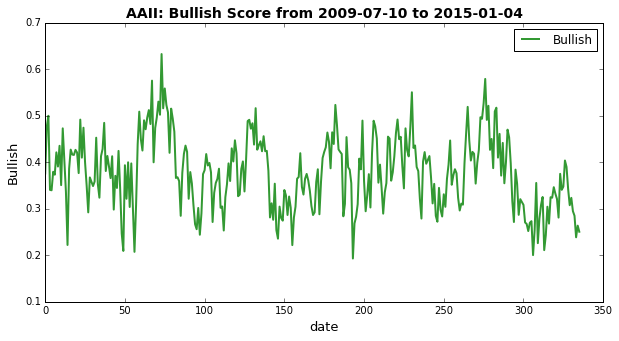

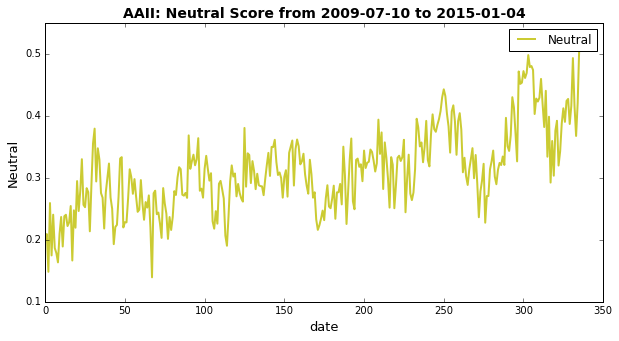

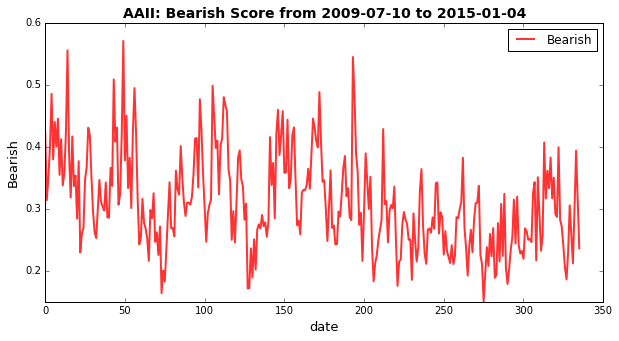

In [14]:
%matplotlib inline
#import numpy as np
import matplotlib.pyplot as plt

#unique_time_stamps = list(pd.unique(df_psch['TIMESTAMP_UTC']))
df_AAII["ReportedDate"] = pd.to_datetime(df_AAII["ReportedDate"])
filtered_df_AAII = df_AAII_float[df_AAII_float['ReportedDate'].isin(unique_time_stamps)].reset_index(drop=True)
# = plot bullish score = #
bullish = filtered_df_AAII["Bullish"]
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlabel(r'date', fontsize=13)
ax.set_ylabel(r'Bullish', fontsize=13)  
ax.plot(bullish, 'g-', lw=2, alpha=0.8, label=r'Bullish')     
ax.legend(ncol=1)
plt.title(r"AAII: Bullish Score from 2009-07-10 to 2015-01-04", fontsize=14, fontweight='bold')
plt.show() 

# = plot neutral score = #
bullish = filtered_df_AAII["Neutral"]
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlabel(r'date', fontsize=13)
ax.set_ylabel(r'Neutral', fontsize=13)  
ax.plot(bullish, 'y-', lw=2, alpha=0.8, label=r'Neutral')     
ax.legend(ncol=1)
plt.title(r"AAII: Neutral Score from 2009-07-10 to 2015-01-04", fontsize=14, fontweight='bold')
plt.show() 

# = plot Bearish score = #
bullish = filtered_df_AAII["Bearish"]
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlabel(r'date', fontsize=13)
ax.set_ylabel(r'Bearish', fontsize=13)  
ax.plot(bullish, 'r-', lw=2, alpha=0.8, label=r'Bearish')     
ax.legend(ncol=1)
plt.title(r"AAII: Bearish Score from 2009-07-10 to 2015-01-04", fontsize=14, fontweight='bold')
plt.show() 





### (2) Correlation-first attempt with the *financial sector*

#### create new Dataframe by filtering current S&P500 against PsychSignal Symbol

In [15]:
df_psy_sp500 = df_GICS[df_GICS['Ticker symbol'].isin(df_psch['SYMBOL'])]
df_psy_sp500

,Ticker symbol,Security,GICS Sector,GICS Sub Industry,Address of Headquarters,Date first added,CIK
0,A,Agilent Technologies Inc,Health Care,Health Care Equipment & Services,"Santa Clara, California",NaN,1090872
1,AA,Alcoa Inc,Materials,Aluminum,"New York, New York",NaN,4281
4,AAPL,Apple Inc.,Information Technology,Computer Hardware,"Cupertino, California",11/30/82,320193
5,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",12/31/12,1551152
6,ABC,AmerisourceBergen Corp,Health Care,Health Care Distribution & Services,"Chesterbrook, Pennsylvania",NaN,1140859
7,ABT,Abbott Laboratories,Health Care,Health Care Equipment & Services,"North Chicago, Illinois",NaN,1800
8,ACN,Accenture plc,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",7/6/11,1467373
9,ADBE,Adobe Systems Inc,Information Technology,Application Software,"San Jose, California",NaN,796343
10,ADI,"Analog Devices, Inc.",Information Technology,Semiconductors,"Norwood, Massachusetts",NaN,6281
11,ADM,Archer-Daniels-Midland Co,Consumer Staples,Agricultural Products,"Decatur, Illinois",7/29/81,7084


#### group ticker by GICS industrial sector

In [16]:
df_psy_sp500.groupby(['GICS Sector']).groups.keys()
sector_name = "Financials"
print("%d symbols are in %s"%(len(df_psy_sp500.groupby(['GICS Sector']).groups[sector_name]), sector_name))

#store all symbols that are inside the financial sector
symbol_in_financials = []
index_in_sector_list = df_psy_sp500.groupby(['GICS Sector']).groups[sector_name]
print (index_in_sector_list)

#counter = 0
#print (df_psy_sp500.loc[488])
for index in range(len(index_in_sector_list)):
    #print(index_in_sector_list[index])
    sbl = df_psy_sp500.loc[index_in_sector_list[index]]['Ticker symbol']
    #counter += 1 
    symbol_in_financials.append(df_psy_sp500.loc[index_in_sector_list[index]]['Ticker symbol'])
    #print (counter)
print (symbol_in_financials)    



80 symbols are in Financials
[20, 22, 23, 24, 26, 31, 33, 34, 38, 45, 48, 51, 54, 58, 62, 63, 70, 71, 77, 78, 81, 91, 94, 96, 102, 126, 150, 159, 163, 165, 182, 196, 208, 214, 217, 218, 221, 232, 236, 247, 253, 256, 258, 268, 276, 278, 281, 287, 294, 297, 298, 303, 313, 316, 320, 322, 335, 349, 358, 360, 364, 366, 373, 374, 387, 400, 412, 416, 418, 438, 441, 442, 456, 461, 469, 473, 479, 488, 493, 502]
['AFL', 'AIG', 'AIV', 'AIZ', 'ALL', 'AMG', 'AMP', 'AMT', 'AON', 'AVB', 'AXP', 'BAC', 'BBT', 'BEN', 'BK', 'BLK', 'BXP', 'C', 'CB', 'CBG', 'CCI', 'CINF', 'CMA', 'CME', 'COF', 'DFS', 'EFX', 'EQR', 'ESS', 'ETFC', 'FITB', 'GGP', 'GS', 'HBAN', 'HCN', 'HCP', 'HIG', 'HST', 'ICE', 'IVZ', 'JPM', 'KEY', 'KIM', 'L', 'LM', 'LNC', 'LUK', 'MAC', 'MCO', 'MET', 'MHFI', 'MMC', 'MS', 'MTB', 'NAVI', 'NDAQ', 'NTRS', 'PBCT', 'PFG', 'PGR', 'PLD', 'PNC', 'PRU', 'PSA', 'RF', 'SCHW', 'SPG', 'STI', 'STT', 'TMK', 'TROW', 'TRV', 'UNM', 'USB', 'VNO', 'VTR', 'WFC', 'WY', 'XL', 'ZION']


#### gen AAII sentiment survey stats: group by year


In [17]:

#get series of time stamp from AAII sentiment survey
#store in @unique_AAII_timeStamps where each element is a pandas.tslib.Timestamp
unique_AAII_timeStamps = list(df_AAII_float[df_AAII_float['ReportedDate'].isin(unique_time_stamps)]['ReportedDate'])
print("There are %d unique AAII time stamps in PsychSignal datasets"%len(unique_AAII_timeStamps))
#df_psch_sorted.groupby(df_psch['TIMESTAMP_UTC'].year)
#grouped = df.groupby(lambda x: x.year)
df_psch_sorted["TIMESTAMP_UTC"] = pd.to_datetime(df_psch_sorted["TIMESTAMP_UTC"])
#by far df_psch_sorted["TIMESTAMP_UTC"][0]:= Timestamp('2009-09-06 00:00:00')
trans = lambda x: x.year
#df_psch_sorted.groupby(trans(df_psch_sorted['TIMESTAMP_UTC'][0]))
#df_psch_sorted["TIMESTAMP_UTC"][0].year
df_timeIndex = df_psch_sorted.set_index('TIMESTAMP_UTC')
#now df_active have TIMESTAMP_UTC as its index
grouped_byYear = df_timeIndex.groupby(lambda x: x.year)
grouped_byYear.describe()

There are 336 unique AAII time stamps in PsychSignal datasets


BULLISH_INTENSITY  BEARISH_INTENSITY  BULL_MINUS_BEAR  \
2009 count        5332.000000        5332.000000      5332.000000   
     mean            0.729527           0.509977         0.219550   
     std             0.976340           0.916705         1.355644   
     min             0.000000           0.000000        -4.000000   
     25%             0.000000           0.000000         0.000000   
     50%             0.000000           0.000000         0.000000   
     75%             1.700000           0.670000         1.190000   
     max             3.560000           4.000000         3.560000   
2010 count       35832.000000       35832.000000     35832.000000   
     mean            0.866720           0.473510         0.393210   
     std             1.007052           0.868591         1.295137   
     min             0.000000           0.000000        -4.000000   
     25%             0.000000           0.000000         0.000000   
     50%             0.000000           0.000000         0.000000   
     75%             1.890000           0.450000         1.500000   
     max             3.890000           4.000000         3.890000   
2011 count      126649.000000      126649.000000    126649.000000   
     mean            0.890902           0.532391         0.358510   
     std             1.011768           0.907919         1.228286   
     min             0.000000           0.000000        -4.000000   
     25%             0.000000           0.000000         0.000000   
     50%             0.000000           0.000000         0.000000   
     75%             1.900000           0.920000         1.300000   
     max             3.890000           4.000000         3.890000   
2012 count      153092.000000      153092.000000    153092.000000   
     mean            1.032769           0.681550         0.351219   
     std             1.053578           1.007006         1.333857   
     min             0.000000           0.000000        -4.000000   
     25%             0.000000           0.000000         0.000000   
     50%             0.970000           0.000000         0.000000   
...                       ...                ...              ...   
2013 std             1.027542           0.941460         1.248416   
     min             0.000000           0.000000        -4.000000   
     25%             0.000000           0.000000         0.000000   
     50%             1.290000           0.000000         0.000000   
     75%             2.000000           1.430000         1.600000   
     max             3.890000           4.000000         3.890000   
2014 count      162156.000000      162156.000000    162156.000000   
     mean            1.125603           0.723098         0.402506   
     std             1.000177           0.997544         1.265243   
     min             0.000000           0.000000        -4.000000   
     25%             0.000000           0.000000         0.000000   
     50%             1.330000           0.000000         0.000000   
     75%             2.000000           1.580000         1.410000   
     max             3.890000           4.000000         3.890000   
2015 count      171083.000000      171083.000000    171083.000000   
     mean            1.473240           0.971464         0.501776   
     std             0.928762           1.085367         1.295973   
     min             0.000000           0.000000        -4.000000   
     25%             0.470000           0.000000        -0.200000   
     50%             1.850000           0.100000         0.110000   
     75%             2.170000           2.010000         1.750000   
     max             3.890000           4.000000         3.890000   
2016 count        1901.000000        1901.000000      1901.000000   
     mean            1.202483           0.770579         0.431904   
     std             0.990018           1.059160         1.280965   
     min             0.000000           0.000000        -3.330000   
     25%  

#### process financial sector

In [18]:
#now we have all the symbol that are inside the financial sector stored in a list
#@symbol_in_financials

#filter df_timeIndex by symbols in the financial sector
#@symbol_in_financials: list of symbols in the financial sector
df_timeIndex_f = df_timeIndex[df_timeIndex['SYMBOL'].isin(symbol_in_financials)]
#now the df_timeIndex_f is PsychSignal dataframe that only contains symbol in the financial sector (sorted by time)
#preview the first 5 entries here
df_timeIndex_f[:5]

,SOURCE,SYMBOL,BULLISH_INTENSITY,BEARISH_INTENSITY,BULL_MINUS_BEAR,BULL_SCORED_MESSAGES,BEAR_SCORED_MESSAGES,BULL_BEAR_MSG_RATIO,TOTAL_SCANNED_MESSAGES
TIMESTAMP_UTC,,,,,,,,,
2009-07-14,stocktwits+twitter_withretweets,GS,1.52,0,1.52,1,0,0,1
2009-07-17,stocktwits+twitter_withretweets,GS,0.00,0,0.00,0,0,0,1
2009-08-06,stocktwits+twitter_withretweets,GS,0.00,0,0.00,0,0,0,3
2009-08-14,stocktwits+twitter_withretweets,MAC,0.00,0,0.00,0,0,0,1
2009-08-14,stocktwits+twitter_withretweets,AXP,0.00,0,0.00,0,0,0,1


In [19]:
#now let's get the aggregated bullish_intensity by time range coming from AAII sentiment survey
#@unique_AAII_timeStamps: stores the unique time stamp from AAII sentiment survey
#@df_timeIndex_f: the dataframe we are going to work on
#print(df.loc['2000-6-1':'2000-6-10'])
bullish_aggregatedScore = []
for t in range(len(unique_AAII_timeStamps)-1):
    #print (unique_AAII_timeStamps[t].date())
    start = str(unique_AAII_timeStamps[t].date())
    end = str(unique_AAII_timeStamps[t+1].date())
    df_sliced = df_timeIndex_f.loc[start:end]
    #print (df_sliced['BULLISH_INTENSITY'].mean())
    #print (df_sliced)
    bullish_aggregatedScore.append(round(df_sliced['BULLISH_INTENSITY'].mean(),3))
    #print (df_sliced['BULLISH_INTENSITY'].mean())

#print (bullish_aggregatedScore)

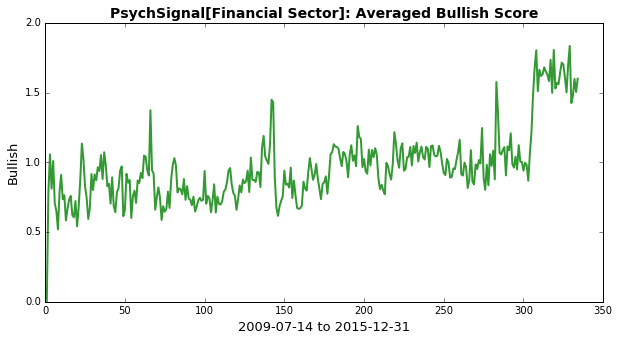

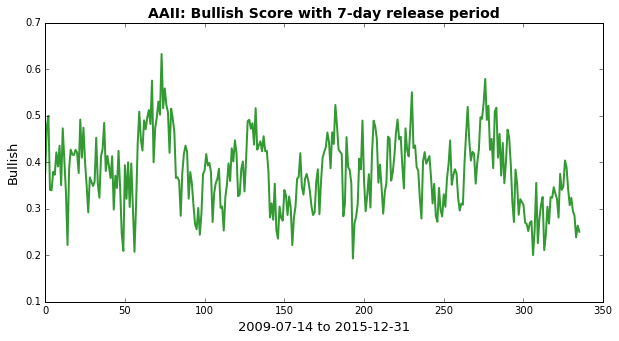

In [20]:
#basic plot of averaged PsychSignal Bullish Score over AAII's 7 day release period
%matplotlib inline
import matplotlib.pyplot as plt

# = plot Bearish score = #
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlabel(r'2009-07-14 to 2015-12-31', fontsize=13)
ax.set_ylabel(r'Bullish', fontsize=13)  
ax.plot(bullish_aggregatedScore, 'g-', lw=2, alpha=0.8, label=r'Bullish')     
#ax.legend(ncol=1)
plt.title(r"PsychSignal[Financial Sector]: Averaged Bullish Score", fontsize=14, fontweight='bold')
plt.show() 

#unique_time_stamps = list(pd.unique(df_psch['TIMESTAMP_UTC']))
df_AAII["ReportedDate"] = pd.to_datetime(df_AAII["ReportedDate"])
filtered_df_AAII = df_AAII_float[df_AAII_float['ReportedDate'].isin(unique_time_stamps)].reset_index(drop=True)
# = plot bullish score = #
bullish = filtered_df_AAII["Bullish"]
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlabel(r'2009-07-14 to 2015-12-31', fontsize=13)
ax.set_ylabel(r'Bullish', fontsize=13)  
ax.plot(bullish, 'g-', lw=2, alpha=0.8, label=r'Bullish')     
#ax.legend(ncol=1)
plt.title(r"AAII: Bullish Score with 7-day release period", fontsize=14, fontweight='bold')
plt.show() 




In [21]:
#print (unique_AAII_timeStamps)